In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xmitgcm 
from IPython.display import display, clear_output
import time

import os
import xarray as xr
import floater

import csv
import pandas as pd
from floater.generators import FloatSet

from matplotlib.colors import LogNorm
from skimage.feature import peak_local_max
from floater import rclv


In [2]:
plt.rcParams.update({'font.size': 18
    , 'legend.markerscale': 1., 'axes.titlesize': 20, 'axes.labelsize' : 20,
      'legend.fontsize' : 18,'legend.handlelength': 3})

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

lw=2
aph=.2

plt.rcParams['figure.figsize'] = (12.,8.)


color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'


In [3]:
codelist = ['100_3Dh', '100_2Dh', '100_3Dd', '100_2Dd',  '100_3Dw', '100_2Dw' ]
indir = '/rigel/ocp/users/as4479/float_traj/'

ddir = 'RCLV_100_partmesh_data/'

In [4]:
lavd_2D_h = xr.open_dataset(indir+'FTLE_LAVD_Depth_%s.nc'%codelist[1]).lavd.fillna(0).to_dataset(name='lavd_2D_h')
lavd_2D_d = xr.open_dataset(indir+'FTLE_LAVD_Depth_%s.nc'%codelist[3]).lavd.fillna(0).to_dataset(name='lavd_2D_d')
lavd_2D_w = xr.open_dataset(indir+'FTLE_LAVD_Depth_%s.nc'%codelist[5]).lavd.fillna(0).to_dataset(name='lavd_2D_w')

lavd_3D_h = xr.open_dataset(indir+'FTLE_LAVD_Depth_%s.nc'%codelist[0]).lavd.fillna(0).to_dataset(name='lavd_3D_h')
lavd_3D_d = xr.open_dataset(indir+'FTLE_LAVD_Depth_%s.nc'%codelist[2]).lavd.fillna(0).to_dataset(name='lavd_3D_d')
lavd_3D_w = xr.open_dataset(indir+'FTLE_LAVD_Depth_%s.nc'%codelist[4]).lavd.fillna(0).to_dataset(name='lavd_3D_w')

lavd1 = xr.merge([lavd_3D_h,lavd_3D_d,lavd_3D_w,lavd_2D_h,lavd_2D_d,lavd_2D_w])
sampling = ['h', 'd', 'w']
particle=['2D', '3D']


lavd = xr.concat([xr.concat([lavd1['lavd_%s_%s' %(part, sam)] for part in particle], 
                            dim=xr.Variable('particle', particle)) for sam in sampling], 
                 dim=xr.Variable('sampling', sampling)).to_dataset(name='lavd')

lavd

<xarray.Dataset>
Dimensions:   (duration: 3, particle: 2, sampling: 3, x0: 4450, y0: 2900)
Coordinates:
  * y0        (y0) float32 -55.995 -55.985 -55.975 -55.965 -55.955 -55.945 ...
  * x0        (x0) float32 -15.495 -15.485 -15.475 -15.465 -15.455 -15.445 ...
  * duration  (duration) int64 15 30 60
  * particle  (particle) <U2 '2D' '3D'
  * sampling  (sampling) <U1 'h' 'd' 'w'
Data variables:
    lavd      (sampling, particle, duration, y0, x0) float64 1.564e-05 ...

In [5]:
ds = lavd.sel(particle='2D', x0=slice(-10,25), y0=slice(-45,-27))
ds

<xarray.Dataset>
Dimensions:   (duration: 3, sampling: 3, x0: 3500, y0: 1800)
Coordinates:
  * y0        (y0) float32 -44.995 -44.985 -44.975 -44.965 -44.955 -44.945 ...
  * x0        (x0) float32 -9.995 -9.985 -9.975 -9.965 -9.955 -9.945 -9.935 ...
  * duration  (duration) int64 15 30 60
    particle  <U2 '2D'
  * sampling  (sampling) <U1 'h' 'd' 'w'
Data variables:
    lavd      (sampling, duration, y0, x0) float64 1.85e-05 1.854e-05 ...

/rigel/ocp/users/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


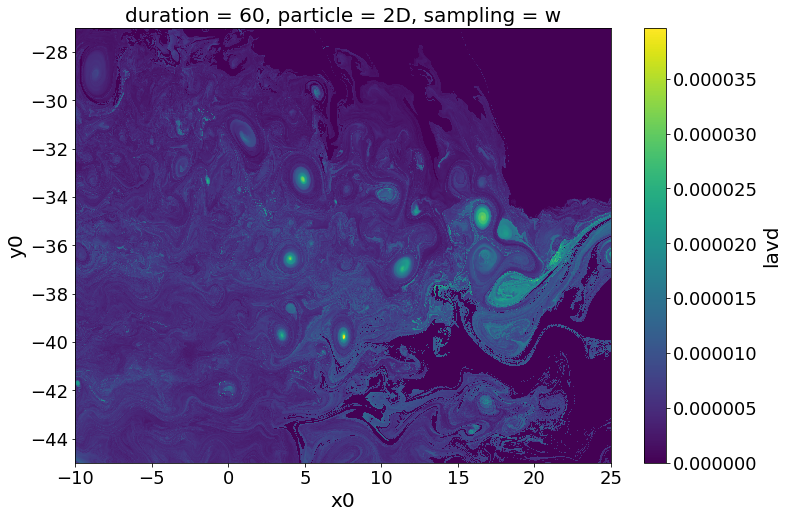

In [7]:
ds.sel(sampling='w', duration=60, x0=slice(-10,25), y0=slice(-45,-27)).lavd.plot()

In [12]:
cd_val = np.array([0.25,0.1,0.05,0.01,0.001])

In [13]:
res_w=[[list(),list(),list(),list(),list()],
     [list(),list(),list(),list(),list()],
     [list(),list(),list(),list(),list()]]
plm_w=[[list(),list(),list(),list(),list()],
     [list(),list(),list(),list(),list()],
     [list(),list(),list(),list(),list()]]

sam = ['h','d','w']
dur = [15 ,30, 60]

cd_val=np.array([0.25,0.1,0.05,0.01,0.001])

for j, dr in enumerate(dur):
    print(j, dr)
    data = ds.lavd.sel(sampling='w', duration = dr)
    raw = data.data
    
    for i, cd in enumerate(cd_val):
        print(i, cd_val[i])
        
        md = 120
        ma = 200.

        plm_w[j][i] = peak_local_max(raw, min_distance=md)
        res_w[j][i] = list(rclv.find_convex_contours(raw, convex_def=cd, min_distance=md, min_area=ma, progress=True))

np.save(ddir+'rclvs_w', res_w)
np.save(ddir+'plms_w', plm_w)


0 15
0 0.25


100%|██████████| 55/55 [19:56<00:00, 21.76s/it]


1 0.1


100%|██████████| 55/55 [19:00<00:00, 20.73s/it]


2 0.05


100%|██████████| 55/55 [07:56<00:00,  8.66s/it]


3 0.01


100%|██████████| 55/55 [00:00<00:00, 84.53it/s]


4 0.001


100%|██████████| 55/55 [00:00<00:00, 287.75it/s]


1 30
0 0.25


100%|██████████| 55/55 [19:36<00:00, 39.79s/it]


1 0.1


100%|██████████| 55/55 [15:26<00:00, 16.85s/it]


2 0.05


100%|██████████| 55/55 [05:53<00:00,  6.43s/it] 


3 0.01


100%|██████████| 55/55 [00:54<00:00,  1.02it/s] 


4 0.001


100%|██████████| 55/55 [00:00<00:00, 285.85it/s]


2 60
0 0.25


100%|██████████| 53/53 [47:49<00:00, 54.15s/it] 


1 0.1


100%|██████████| 53/53 [17:20<00:00, 19.63s/it]


2 0.05


100%|██████████| 53/53 [03:02<00:00,  3.44s/it]


3 0.01


100%|██████████| 53/53 [00:00<00:00, 88.63it/s] 


4 0.001


100%|██████████| 53/53 [00:00<00:00, 171.67it/s]


In [9]:
res_w = np.load(ddir+'rclvs_w.npy')

Text(0.5,1,'60d')

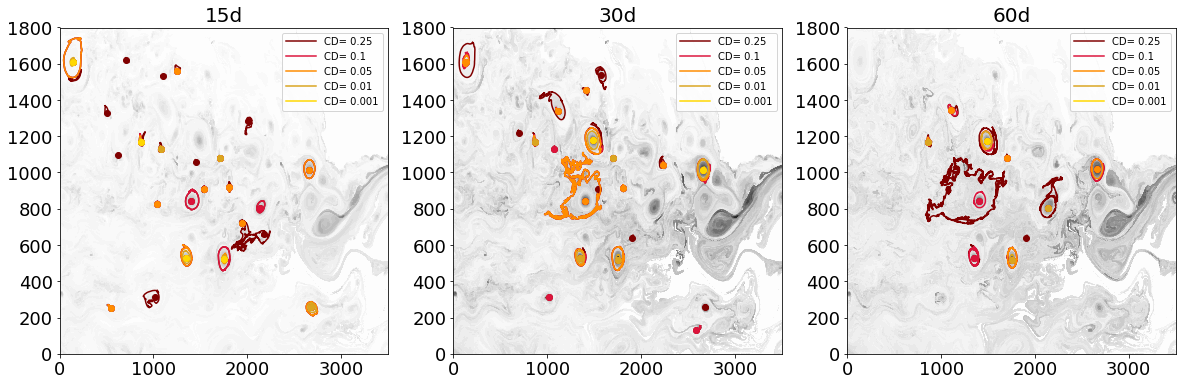

In [15]:
plt.figure(figsize=(20,6))
dur = [15 ,30, 60]
cd_val = np.array([0.25,0.1,0.05,0.01,0.001])
colors = ['maroon','crimson','darkorange','goldenrod','gold']

plt.subplot(131)

plt.contourf(ds.lavd.sel(sampling='w', duration = dur[0]).data, 30)
plt.set_cmap('Greys')
#plt.plot(plm_w[0][2][:, 1], plm_w[0][2][:, 0], 'co')
#colors = [color1,color2,color3,color4,color5,color6]

for j, clr in zip(range(5), colors):
    for (ji, con, area, cd) in res_w[0][j]:
        plt.plot(ji[1], ji[0], color = clr,  marker='o')
        plt.plot(con[:, 1], con[:, 0], color = clr,  linestyle='solid', label='CD= %s' %cd_val[j])
plt.legend(fontsize=10)
plt.title('15d')

plt.subplot(132)
plt.contourf(ds.lavd.sel(sampling='w', duration = dur[1]).data, 30)
plt.set_cmap('Greys')
#plt.plot(plm_w[0][2][:, 1], plm_w[0][2][:, 0], 'co')

for j, clr in zip(range(5), colors):
    for (ji, con, area, cd) in res_w[1][j]:
        plt.plot(ji[1], ji[0], color = clr,  marker='o')
        plt.plot(con[:, 1], con[:, 0], color = clr,  linestyle='solid', label='CD= %s' %cd_val[j])
plt.legend(fontsize=10)
plt.title('30d')

plt.subplot(133)
plt.contourf(ds.lavd.sel(sampling='w', duration = dur[2]).data, 30)
plt.set_cmap('Greys')
#plt.plot(plm_w[0][2][:, 1], plm_w[0][2][:, 0], 'co')

for j, clr in zip(range(5), colors):
    for (ji, con, area, cd) in res_w[2][j]:
        plt.plot(ji[1], ji[0], color = clr,  marker='o')
        plt.plot(con[:, 1], con[:, 0], color = clr,  linestyle='solid', label='CD= %s' %cd_val[j])
plt.legend(fontsize=10)
plt.title('60d')



In [16]:
res_d=[[list(),list(),list(),list(),list()],
     [list(),list(),list(),list(),list()],
     [list(),list(),list(),list(),list()]]
plm_d=[[list(),list(),list(),list(),list()],
     [list(),list(),list(),list(),list()],
     [list(),list(),list(),list(),list()]]

sam = ['h','d','w']
dur = [15 ,30, 60]

cd_val=np.array([0.25,0.1,0.05,0.01,0.001])

for j, dr in enumerate(dur):
    print(j, dr)
    data = ds.lavd.sel(sampling='d', duration = dr)
    raw = data.data
    
    for i, cd in enumerate(cd_val):
        print(i, cd_val[i])
        
        md = 120
        ma = 200.

        plm_d[j][i] = peak_local_max(raw, min_distance=md)
        res_d[j][i] = list(rclv.find_convex_contours(raw, convex_def=cd, min_distance=md, min_area=ma, progress=True))

np.save(ddir+'rclvs_d', res_d)
np.save(ddir+'plms_d', plm_d)


0 15
0 0.25


100%|██████████| 52/52 [00:01<00:00, 37.41it/s]


1 0.1


100%|██████████| 52/52 [00:01<00:00, 43.20it/s]


2 0.05


100%|██████████| 52/52 [00:01<00:00, 45.59it/s]


3 0.01


100%|██████████| 52/52 [00:01<00:00, 47.00it/s]


4 0.001


100%|██████████| 52/52 [00:00<00:00, 321.55it/s]


1 30
0 0.25


100%|██████████| 44/44 [00:19<00:00,  2.25it/s]


1 0.1


100%|██████████| 44/44 [00:19<00:00,  2.24it/s]


2 0.05


100%|██████████| 44/44 [00:19<00:00,  2.23it/s]


3 0.01


100%|██████████| 44/44 [00:01<00:00, 40.48it/s]


4 0.001


100%|██████████| 44/44 [00:00<00:00, 283.18it/s]


2 60
0 0.25


100%|██████████| 39/39 [10:11<00:00, 15.68s/it]


1 0.1


100%|██████████| 39/39 [10:11<00:00, 15.68s/it]


2 0.05


100%|██████████| 39/39 [10:12<00:00, 15.71s/it]


3 0.01


100%|██████████| 39/39 [01:37<00:00,  2.51s/it]


4 0.001


100%|██████████| 39/39 [00:00<00:00, 413.49it/s]


No handles with labels found to put in legend.


Text(0.5,1,'60d')

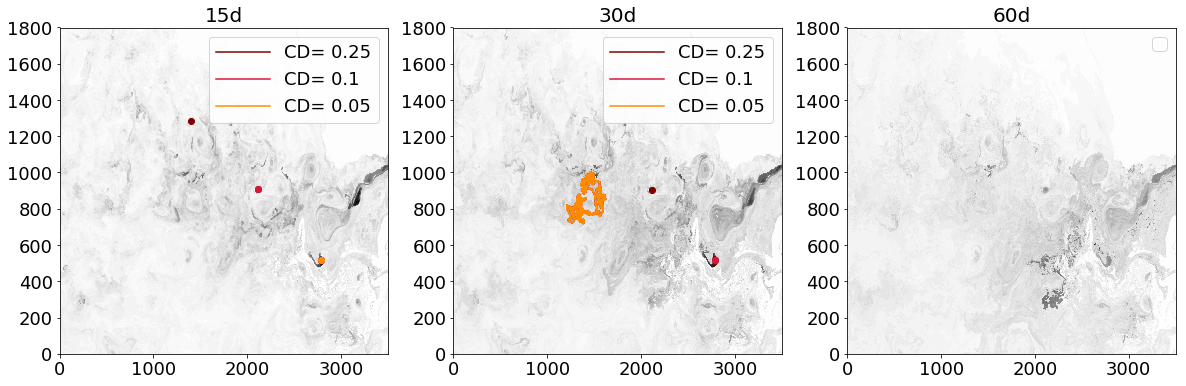

In [17]:
plt.figure(figsize=(20,6))
colors = ['maroon','crimson','darkorange','goldenrod','gold']

plt.subplot(131)
plt.contourf(ds.lavd.sel(sampling='d', duration = dur[0]).data, 30)
plt.set_cmap('Greys')
#plt.plot(plm_w[0][2][:, 1], plm_w[0][2][:, 0], 'co')

for j, clr in zip(range(5), colors):
    for (ji, con, area, cd) in res_d[0][j]:
        plt.plot(ji[1], ji[0], color = clr,  marker='o')
        plt.plot(con[:, 1], con[:, 0], color = clr,  linestyle='solid', label='CD= %s' %cd_val[j])
plt.legend()
plt.title('15d')

plt.subplot(132)
plt.contourf(ds.lavd.sel(sampling='d', duration = dur[1]).data, 30)
plt.set_cmap('Greys')
#plt.plot(plm_w[0][2][:, 1], plm_w[0][2][:, 0], 'co')

for j, clr in zip(range(5), colors):
    for (ji, con, area, cd) in res_d[1][j]:
        plt.plot(ji[1], ji[0], color = clr,  marker='o')
        plt.plot(con[:, 1], con[:, 0], color = clr,  linestyle='solid', label='CD= %s' %cd_val[j])
plt.legend()
plt.title('30d')

plt.subplot(133)
plt.contourf(ds.lavd.sel(sampling='d', duration = dur[2]).data, 30)
plt.set_cmap('Greys')
#plt.plot(plm_w[0][2][:, 1], plm_w[0][2][:, 0], 'co')

for j, clr in zip(range(5), colors):
    for (ji, con, area, cd) in res_d[2][j]:
        plt.plot(ji[1], ji[0], color = clr,  marker='o')
        plt.plot(con[:, 1], con[:, 0], color = clr,  linestyle='solid', label='CD= %s' %cd_val[j])
plt.legend()
plt.title('60d')



In [18]:
res_h=[[list(),list(),list(),list(),list()],
     [list(),list(),list(),list(),list()],
     [list(),list(),list(),list(),list()]]
plm_h=[[list(),list(),list(),list(),list()],
     [list(),list(),list(),list(),list()],
     [list(),list(),list(),list(),list()]]

sam = ['h','d','w']
dur = [15 ,30, 60]

cd_val=np.array([0.25,0.1,0.05,0.01,0.001])

for j, dr in enumerate(dur):
    print(j, dr)
    data = ds.lavd.sel(sampling='h', duration = dr)
    raw = data.data
    
    for i, cd in enumerate(cd_val):
        print(i, cd_val[i])
        
        md = 120
        ma = 200.

        plm_h[j][i] = peak_local_max(raw, min_distance=md)
        res_h[j][i] = list(rclv.find_convex_contours(raw, convex_def=cd, min_distance=md, min_area=ma, progress=True))

np.save(ddir+'rclvs_h', res_h)
np.save(ddir+'plms_h', plm_h)


0 15
0 0.25


100%|██████████| 47/47 [07:38<00:00,  9.76s/it] 


1 0.1


100%|██████████| 47/47 [07:37<00:00,  9.73s/it]


2 0.05


100%|██████████| 47/47 [02:06<00:00,  2.70s/it]


3 0.01


100%|██████████| 47/47 [02:07<00:00,  2.72s/it]


4 0.001


100%|██████████| 47/47 [00:00<00:00, 327.27it/s]


1 30
0 0.25


100%|██████████| 37/37 [06:26<00:00, 10.46s/it]


1 0.1


100%|██████████| 37/37 [01:18<00:00,  2.11s/it]


2 0.05


100%|██████████| 37/37 [00:09<00:00,  3.95it/s]


3 0.01


100%|██████████| 37/37 [00:06<00:00,  5.66it/s] 


4 0.001


100%|██████████| 37/37 [00:00<00:00, 442.44it/s]


2 60
0 0.25


100%|██████████| 42/42 [07:15<00:00, 10.38s/it]


1 0.1


100%|██████████| 42/42 [03:15<00:00,  4.65s/it]


2 0.05


100%|██████████| 42/42 [02:50<00:00,  1.72it/s]


3 0.01


100%|██████████| 42/42 [02:46<00:00,  1.21it/s]


4 0.001


100%|██████████| 42/42 [00:00<00:00, 244.26it/s]


Text(0.5,1,'60d')

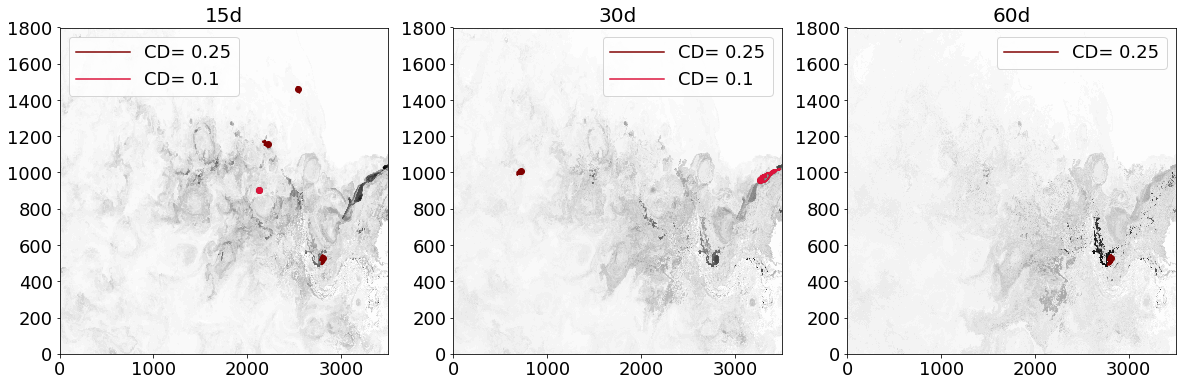

In [19]:
plt.figure(figsize=(20,6))

plt.subplot(131)
plt.contourf(ds.lavd.sel(sampling='h', duration = dur[0]).data, 30)
plt.set_cmap('Greys')
#plt.plot(plm_w[0][2][:, 1], plm_w[0][2][:, 0], 'co')
colors = ['maroon','crimson','darkorange','goldenrod','gold']

for j, clr in zip(range(5), colors):
    for (ji, con, area, cd) in res_h[0][j]:
        plt.plot(ji[1], ji[0], color = clr,  marker='o')
        plt.plot(con[:, 1], con[:, 0], color = clr,  linestyle='solid', label='CD= %s' %cd_val[j])
plt.legend()
plt.title('15d')

plt.subplot(132)
plt.contourf(ds.lavd.sel(sampling='h', duration = dur[1]).data, 30)
plt.set_cmap('Greys')
#plt.plot(plm_w[0][2][:, 1], plm_w[0][2][:, 0], 'co')

for j, clr in zip(range(5), colors):
    for (ji, con, area, cd) in res_h[1][j]:
        plt.plot(ji[1], ji[0], color = clr,  marker='o')
        plt.plot(con[:, 1], con[:, 0], color = clr,  linestyle='solid', label='CD= %s' %cd_val[j])
plt.legend()
plt.title('30d')

plt.subplot(133)
plt.contourf(ds.lavd.sel(sampling='h', duration = dur[2]).data, 30)
plt.set_cmap('Greys')
#plt.plot(plm_w[0][2][:, 1], plm_w[0][2][:, 0], 'co')

for j, clr in zip(range(5), colors):
    for (ji, con, area, cd) in res_h[2][j]:
        plt.plot(ji[1], ji[0], color = clr,  marker='o')
        plt.plot(con[:, 1], con[:, 0], color = clr,  linestyle='solid', label='CD= %s' %cd_val[j])
plt.legend()
plt.title('60d')



In [14]:
rclvs_w = np.load(ddir+'rclvs_w.npy')
rclvs_d = np.load(ddir+'rclvs_d.npy') 
rclvs_h = np.load(ddir+'rclvs_h.npy')

len_rclvs_w = np.zeros((3,5))
len_rclvs_d = np.zeros((3,5))
len_rclvs_h = np.zeros((3,5))

for i in range(3):
    for j in range(5):
        len_rclvs_w[i,j] = len(rclvs_w[i,j])
        len_rclvs_d[i,j] = len(rclvs_d[i,j])
        len_rclvs_h[i,j] = len(rclvs_h[i,j])
        
len_rclvs = np.array([len_rclvs_w,len_rclvs_d,len_rclvs_h])
len_rclvs.shape

(3, 3, 5)

In [20]:
len_rclvs

array([[[ 24.,  16.,  14.,   7.,   4.],
        [ 20.,  15.,  12.,   6.,   2.],
        [ 10.,   9.,   7.,   4.,   1.]],

       [[  3.,   2.,   1.,   0.,   0.],
        [  3.,   2.,   1.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]],

       [[  4.,   1.,   0.,   0.,   0.],
        [  2.,   1.,   0.,   0.,   0.],
        [  1.,   0.,   0.,   0.,   0.]]])

In [23]:
len_rclvs[2,0,0]

4.0

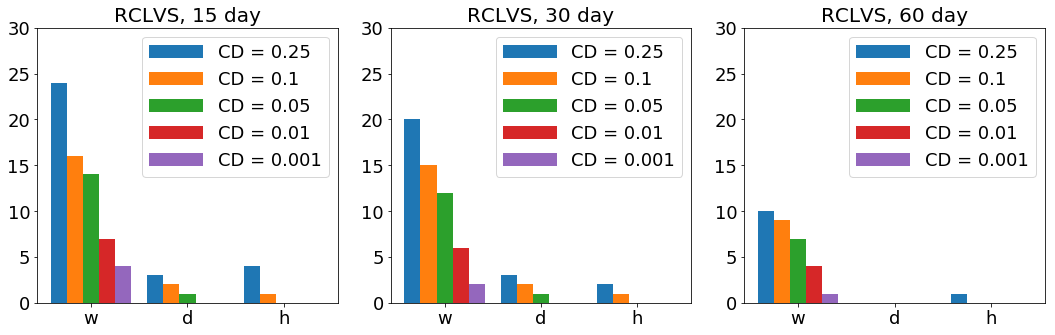

In [27]:
fig = plt.figure(figsize=(15,5))
figdir = 'Figs_FTLE_LAVD_Depth_100particlegrid/'

xlabel = (['w', 'd', 'h'])
x0 = ([0,12,24])
x1 = ([2,14,26])
x2 = ([4,16,28])
x3 = ([6,18,30])
x4 = ([8,20,32])

plt.subplot(131)

plt.bar(x0, len_rclvs[:,0,0], width=2, label = 'CD = 0.25', rasterized=True)
plt.bar(x1, len_rclvs[:,0,1], width=2, label = 'CD = 0.1', rasterized=True)
plt.bar(x2, len_rclvs[:,0,2], width=2, label = 'CD = 0.05', rasterized=True)
plt.bar(x3, len_rclvs[:,0,3], width=2, label = 'CD = 0.01', rasterized=True)
plt.bar(x4, len_rclvs[:,0,4], width=2, label = 'CD = 0.001', rasterized=True)
plt.title('RCLVS, 15 day')

plt.xticks([4,16,28],xlabel);
#plt.yscale('log')
plt.ylim([0,30])
plt.legend()

plt.subplot(132)

plt.bar(x0, len_rclvs[:,1,0], width=2, label = 'CD = 0.25', rasterized=True)
plt.bar(x1, len_rclvs[:,1,1], width=2, label = 'CD = 0.1', rasterized=True)
plt.bar(x2, len_rclvs[:,1,2], width=2, label = 'CD = 0.05', rasterized=True)
plt.bar(x3, len_rclvs[:,1,3], width=2, label = 'CD = 0.01', rasterized=True)
plt.bar(x4, len_rclvs[:,1,4], width=2, label = 'CD = 0.001', rasterized=True)
plt.title('RCLVS, 30 day')

plt.xticks([4,16,28],xlabel);
#plt.yscale('log')
plt.ylim([0,30])
plt.legend()

plt.subplot(133)
#plt.bar(x0, len_rclvs[:,0,0], width=2, label = 'CD = 0.5', rasterized=True)
plt.bar(x0, len_rclvs[:,2,0], width=2, label = 'CD = 0.25', rasterized=True)
plt.bar(x1, len_rclvs[:,2,1], width=2, label = 'CD = 0.1', rasterized=True)
plt.bar(x2, len_rclvs[:,2,2], width=2, label = 'CD = 0.05', rasterized=True)
plt.bar(x3, len_rclvs[:,2,3], width=2, label = 'CD = 0.01', rasterized=True)
plt.bar(x4, len_rclvs[:,2,4], width=2, label = 'CD = 0.001', rasterized=True)
plt.title('RCLVS, 60 day')

plt.xticks([4,16,28],xlabel);
#plt.yscale('log')
plt.ylim([0,30])
plt.legend()
plt.tight_layout()

fig.savefig(figdir+'RCLV_15_30_60day_stats.pdf', dpi=150)

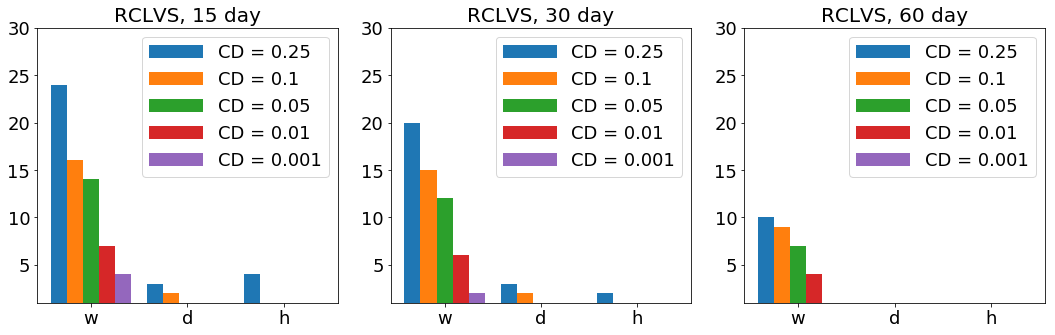

In [28]:
fig = plt.figure(figsize=(15,5))
figdir = 'Figs_FTLE_LAVD_Depth_100particlegrid/'

xlabel = (['w', 'd', 'h'])
x0 = ([0,12,24])
x1 = ([2,14,26])
x2 = ([4,16,28])
x3 = ([6,18,30])
x4 = ([8,20,32])

plt.subplot(131)

plt.bar(x0, len_rclvs[:,0,0], width=2, label = 'CD = 0.25', rasterized=True)
plt.bar(x1, len_rclvs[:,0,1], width=2, label = 'CD = 0.1', rasterized=True)
plt.bar(x2, len_rclvs[:,0,2], width=2, label = 'CD = 0.05', rasterized=True)
plt.bar(x3, len_rclvs[:,0,3], width=2, label = 'CD = 0.01', rasterized=True)
plt.bar(x4, len_rclvs[:,0,4], width=2, label = 'CD = 0.001', rasterized=True)
plt.title('RCLVS, 15 day')

plt.xticks([4,16,28],xlabel);
#plt.yscale('log')
plt.ylim([1,30])
plt.legend()

plt.subplot(132)

plt.bar(x0, len_rclvs[:,1,0], width=2, label = 'CD = 0.25', rasterized=True)
plt.bar(x1, len_rclvs[:,1,1], width=2, label = 'CD = 0.1', rasterized=True)
plt.bar(x2, len_rclvs[:,1,2], width=2, label = 'CD = 0.05', rasterized=True)
plt.bar(x3, len_rclvs[:,1,3], width=2, label = 'CD = 0.01', rasterized=True)
plt.bar(x4, len_rclvs[:,1,4], width=2, label = 'CD = 0.001', rasterized=True)
plt.title('RCLVS, 30 day')

plt.xticks([4,16,28],xlabel);
#plt.yscale('log')
plt.ylim([1,30])
plt.legend()

plt.subplot(133)
#plt.bar(x0, len_rclvs[:,0,0], width=2, label = 'CD = 0.5', rasterized=True)
plt.bar(x0, len_rclvs[:,2,0], width=2, label = 'CD = 0.25', rasterized=True)
plt.bar(x1, len_rclvs[:,2,1], width=2, label = 'CD = 0.1', rasterized=True)
plt.bar(x2, len_rclvs[:,2,2], width=2, label = 'CD = 0.05', rasterized=True)
plt.bar(x3, len_rclvs[:,2,3], width=2, label = 'CD = 0.01', rasterized=True)
plt.bar(x4, len_rclvs[:,2,4], width=2, label = 'CD = 0.001', rasterized=True)
plt.title('RCLVS, 60 day')

plt.xticks([4,16,28],xlabel);
#plt.yscale('log')
plt.ylim([1,30])
plt.legend()
plt.tight_layout()

fig.savefig(figdir+'RCLV_15_30_60day_stats2.pdf', dpi=150)

In [4]:
lavd_2D_h = xr.open_dataset(indir+'lavd_1_5_10_%s.nc'%codelist[1]).lavd.fillna(0).to_dataset(name='lavd_2D_h')
lavd_2D_d = xr.open_dataset(indir+'lavd_1_5_10_%s.nc'%codelist[3]).lavd.fillna(0).to_dataset(name='lavd_2D_d')
lavd_2D_w = xr.open_dataset(indir+'lavd_1_5_10_%s.nc'%codelist[5]).lavd.fillna(0).to_dataset(name='lavd_2D_w')

lavd_3D_h = xr.open_dataset(indir+'lavd_1_5_10_%s.nc'%codelist[0]).lavd.fillna(0).to_dataset(name='lavd_3D_h')
lavd_3D_d = xr.open_dataset(indir+'lavd_1_5_10_%s.nc'%codelist[2]).lavd.fillna(0).to_dataset(name='lavd_3D_d')
lavd_3D_w = xr.open_dataset(indir+'lavd_1_5_10_%s.nc'%codelist[4]).lavd.fillna(0).to_dataset(name='lavd_3D_w')

lavd1 = xr.merge([lavd_3D_h,lavd_3D_d,lavd_3D_w,lavd_2D_h,lavd_2D_d,lavd_2D_w])
sampling = ['h', 'd', 'w']
particle=['2D', '3D']


lavd = xr.concat([xr.concat([lavd1['lavd_%s_%s' %(part, sam)] for part in particle], 
                            dim=xr.Variable('particle', particle)) for sam in sampling], 
                 dim=xr.Variable('sampling', sampling)).to_dataset(name='lavd')

lavd

<xarray.Dataset>
Dimensions:   (duration: 3, particle: 2, sampling: 3, x0: 4450, y0: 2900)
Coordinates:
  * y0        (y0) float32 -55.995 -55.985 -55.975 -55.965 -55.955 -55.945 ...
  * x0        (x0) float32 -15.495 -15.485 -15.475 -15.465 -15.455 -15.445 ...
  * duration  (duration) int64 1 5 10
  * particle  (particle) <U2 '2D' '3D'
  * sampling  (sampling) <U1 'h' 'd' 'w'
Data variables:
    lavd      (sampling, particle, duration, y0, x0) float64 7.268e-05 ...

In [5]:
ds = lavd.sel(particle='2D', x0=slice(-10,25), y0=slice(-45,-27))

In [6]:
res_w_5d=[list(),list(),list(),list(),list()]
plm_w_5d=[list(),list(),list(),list(),list()]

sam = ['h','d','w']
dur = 5

cd_val=np.array([0.25,0.1,0.05,0.01,0.001])


data = ds.lavd.sel(sampling='w', duration = dur)
raw = data.data
    
for i, cd in enumerate(cd_val):
    print(i, cd_val[i])
        
    md = 120
    ma = 200.

    plm_w_5d[i] = peak_local_max(raw, min_distance=md)
    res_w_5d[i] = list(rclv.find_convex_contours(raw, convex_def=cd, min_distance=md, min_area=ma, progress=True))

np.save(ddir+'rclvs_w_5d', res_w_5d)
np.save(ddir+'plms_w_5d', plm_w_5d)


0 0.25


100%|██████████| 67/67 [17:21<00:00, 15.54s/it]


1 0.1


100%|██████████| 67/67 [10:01<00:00,  8.98s/it]


2 0.05


100%|██████████| 67/67 [02:03<00:00,  1.85s/it] 


3 0.01


100%|██████████| 67/67 [00:24<00:00,  2.78it/s] 


4 0.001


100%|██████████| 67/67 [00:00<00:00, 414.96it/s]


Text(0.5,1,'5d')

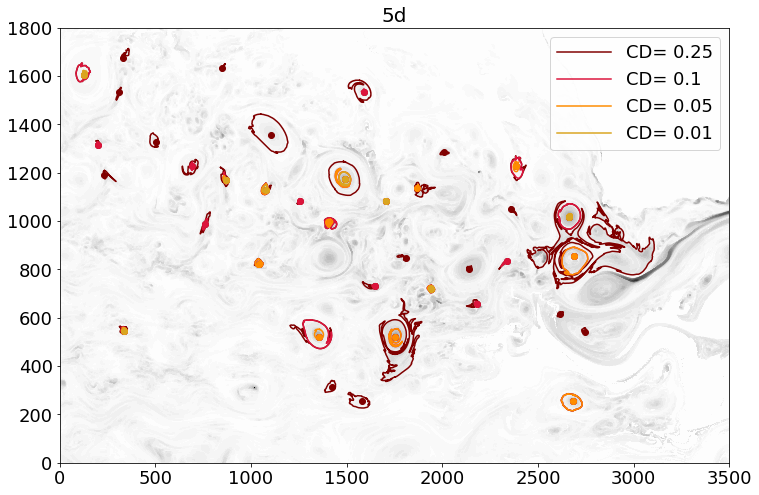

In [10]:
plt.contourf(ds.lavd.sel(sampling='w', duration = 5).data, 30)
plt.set_cmap('Greys')
#plt.plot(plm_w[0][2][:, 1], plm_w[0][2][:, 0], 'co')
colors = ['maroon','crimson','darkorange','goldenrod','gold']

for j, clr in zip(range(5), colors):
    for (ji, con, area, cd) in res_w_5d[j]:
        plt.plot(ji[1], ji[0], color = clr,  marker='o')
        plt.plot(con[:,1], con[:,0], color = clr,  linestyle='solid', label='CD= %s' %cd_val[j])
plt.legend()
plt.title('5d')

In [7]:
res_d_5d=[list(),list(),list(),list(),list()]
plm_d_5d=[list(),list(),list(),list(),list()]

sam = ['h','d','w']
dur = 5

cd_val=np.array([0.25,0.1,0.05,0.01,0.001])


data = ds.lavd.sel(sampling='d', duration = dur)
raw = data.data
    
for i, cd in enumerate(cd_val):
    print(i, cd_val[i])
        
    md = 120
    ma = 200.

    plm_d_5d[i] = peak_local_max(raw, min_distance=md)
    res_d_5d[i] = list(rclv.find_convex_contours(raw, convex_def=cd, min_distance=md, min_area=ma, progress=True))

np.save(ddir+'rclvs_d_5d', res_d_5d)
np.save(ddir+'plms_d_5d', plm_d_5d)


0 0.25


100%|██████████| 62/62 [03:11<00:00,  3.08s/it]


1 0.1


100%|██████████| 62/62 [00:49<00:00,  1.25it/s]


2 0.05


100%|██████████| 62/62 [00:32<00:00,  1.93it/s]


3 0.01


100%|██████████| 62/62 [00:00<00:00, 75.90it/s]


4 0.001


100%|██████████| 62/62 [00:00<00:00, 429.71it/s]


Text(0.5,1,'5d')

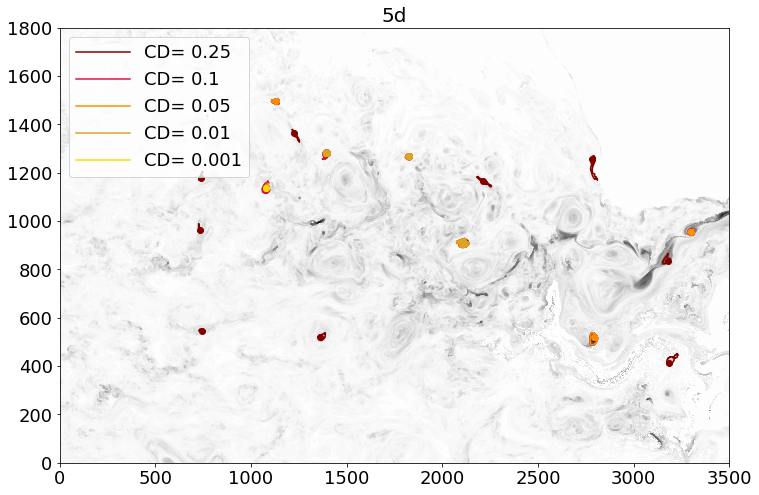

In [11]:
plt.contourf(ds.lavd.sel(sampling='d', duration = 5).data, 30)
plt.set_cmap('Greys')
#plt.plot(plm_w[0][2][:, 1], plm_w[0][2][:, 0], 'co')
colors = ['maroon','crimson','darkorange','goldenrod','gold']

for j, clr in zip(range(5), colors):
    for (ji, con, area, cd) in res_d_5d[j]:
        plt.plot(ji[1], ji[0], color = clr,  marker='o')
        plt.plot(con[:,1], con[:,0], color = clr,  linestyle='solid', label='CD= %s' %cd_val[j])
plt.legend()
plt.title('5d')

In [8]:
res_h_5d=[list(),list(),list(),list(),list()]
plm_h_5d=[list(),list(),list(),list(),list()]

sam = ['h','d','w']
dur = 5

cd_val=np.array([0.25,0.1,0.05,0.01,0.001])


data = ds.lavd.sel(sampling='h', duration = dur)
raw = data.data
    
for i, cd in enumerate(cd_val):
    print(i, cd_val[i])
        
    md = 120
    ma = 200.

    plm_h_5d[i] = peak_local_max(raw, min_distance=md)
    res_h_5d[i] = list(rclv.find_convex_contours(raw, convex_def=cd, min_distance=md, min_area=ma, progress=True))

np.save(ddir+'rclvs_h_5d', res_d_5d)
np.save(ddir+'plms_h_5d', plm_d_5d)


0 0.25


100%|██████████| 57/57 [13:35<00:00, 14.31s/it] 


1 0.1


100%|██████████| 57/57 [00:17<00:00,  3.31it/s] 


2 0.05


100%|██████████| 57/57 [00:17<00:00,  3.32it/s] 


3 0.01


100%|██████████| 57/57 [00:17<00:00,  3.33it/s] 


4 0.001


100%|██████████| 57/57 [00:00<00:00, 362.72it/s]


Text(0.5,1,'5d')

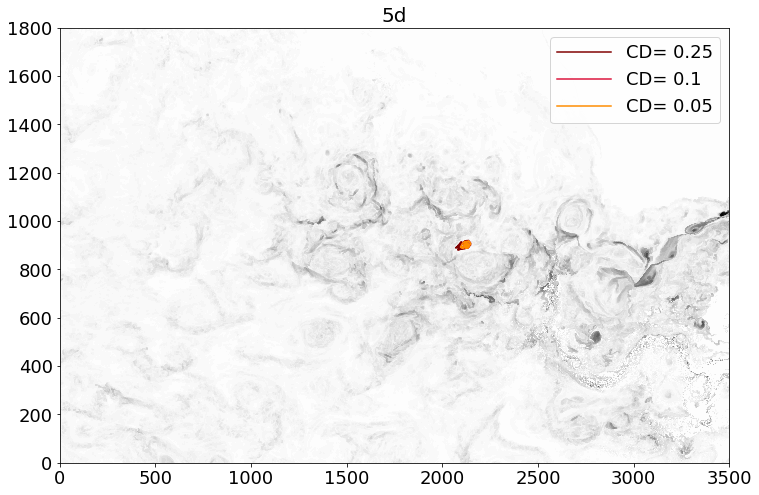

In [12]:
plt.contourf(ds.lavd.sel(sampling='h', duration = 5).data, 30)
plt.set_cmap('Greys')
#plt.plot(plm_w[0][2][:, 1], plm_w[0][2][:, 0], 'co')
colors = ['maroon','crimson','darkorange','goldenrod','gold']

for j, clr in zip(range(5), colors):
    for (ji, con, area, cd) in res_h_5d[j]:
        plt.plot(ji[1], ji[0], color = clr,  marker='o')
        plt.plot(con[:,1], con[:,0], color = clr,  linestyle='solid', label='CD= %s' %cd_val[j])
plt.legend()
plt.title('5d')